In [49]:
from random import random
import numpy as np
import mpmath as mp
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
from sympy import symbols, exp, laplace_transform, inverse_laplace_transform, solve
from scipy.integrate import quad
from scipy.optimize import root_scalar
import heapq
import torch
import seaborn as sns
import pandas as pd
import itertools
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep", n_colors=13)
np.random.seed(77)

In [58]:
def sim_clock(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_clock = [tg.sim_clock(int(_c), trace, raw=True) for _c in c]
    return c, hr_clock

def sim_fifo(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_fifo = [tg.sim_fifo(int(_c), trace, raw=True) for _c in c]
    return c, hr_fifo

def clock_irm(lmb, tc): 
    x = lmb * tc
    pm_i = 1.0/(1 + x*np.exp(x))
    pm = np.sum(lmb*pm_i)      
    occ = np.sum(lmb*pm_i*np.exp(x))    
    C = (tc * occ)
    ph = (1 - pm)
    return C, ph

def clock_he(lmb, tc, eps=1e-5, max_rounds=2000):
    lam = np.asarray(lmb, dtype=np.float64).ravel()
    lam /= lam.sum()
    M = len(lam)
    one_minus = 1.0 - lam
    # Upper‐left: (I - Λ)
    UL = np.diag(one_minus)
    # Upper‐right: λ · λ^T   (since r_j = λ_j)
    UR = lam[:, None] * lam[None, :]
    # Lower‐left: zero
    LL = np.zeros((M, M))
    # Lower‐right: (I - Λ) + (λ · λ^T)
    LR = np.diag(one_minus) + lam[:, None] * lam[None, :]
    P = np.block([[UL, UR],
                  [LL, LR]]) 
    p = np.concatenate([lam, np.zeros(M)]) 
    R_L, H_L, O_L = 1.0, 0.0, 1.0
    for _ in range(max_rounds):
        hits = 0.0
        p_t = p.copy()
        for _ in range(int(tc)):
            hits += np.dot(lam, p_t[:M] + p_t[M:])
            p_t = p_t.dot(P)
        P_evict = p_t[:M].sum()
        R_next  = 1.0 - P_evict
        H_L += R_L * hits
        R_L *= R_next
        O_L += R_L
        if R_L < eps or R_next == 0.0:
            break
        survivors = p_t[M:]     
        rho_next = survivors / R_next
        p = np.concatenate([rho_next, np.zeros(M)])
    P_miss = 1.0 / (1.0 + H_L)
    C = int(round(tc * O_L * P_miss))
    return C, 1.0 - P_miss

def fifo_irm(lmb, tc):
    pm = np.sum(lmb/(1 + lmb*tc))
    C = tc * pm
    ph = 1 - pm
    return C, ph

def fifo_he(lmb, tc, method="talbot"):
    lam = [mp.mpf(x) for x in np.asarray(lmb, dtype=np.float64).ravel()]
    t = mp.mpf(tc)
    def _m_of_s(s):
        F = mp.mpf("0")
        f = mp.mpf("0")
        for li in lam:
            li2 = li * li
            F += li2 / (s * (s + li))
            f += li2 / (s + li)
        return F / (1 - f)
    m_tc = mp.invertlaplace(_m_of_s, t, method=method)
    m_tc = float(m_tc)
    P_miss = 1.0 / (1.0 + m_tc)
    C = tc * P_miss
    return C, 1.0 - P_miss

def gen_from_zipf(M, n, a):
    p = 1.0 / np.power(np.arange(1, M + 1), a)
    p = p / p.sum()
    return p, np.random.choice(M, size=n, p=p)

def gen_from_he(m, a, n):
    p = 1.0 / np.power(np.arange(1, m + 1), a)
    p = p / p.sum()
    cp = np.cumsum(p)
    t = p.copy()
    phases = np.searchsorted(cp, np.random.random(m), side="right")
    next_times = np.random.exponential(1.0 / t[phases])
    heap = [(next_times[i], i) for i in range(m)]
    heapq.heapify(heap)
    trace = np.empty(n, dtype=np.int32)
    for idx in range(n):
        ctime, item = heapq.heappop(heap)
        trace[idx] = item + 1
        phases[item] = np.searchsorted(cp, np.random.random(), side="right")
        next_time = ctime + np.random.exponential(1.0 / t[phases[item]])
        heapq.heappush(heap, (next_time, item))
    return trace

import numpy as np, heapq

def gen_from_ph(alphas, Ts, length):
    A = np.asarray(alphas, np.float64)
    T = np.asarray(Ts, np.float64)
    n, m = A.shape
    A = A / A.sum(axis=1, keepdims=True)
    A_cdf = np.cumsum(A, axis=1)
    A_cdf[:, -1] = 1.0

    one = np.ones(m, np.float64)
    mu = -(T @ one)
    off = T.copy()
    idx = np.arange(m)
    off[:, idx, idx] = 0.0
    rdiag = -np.diagonal(T, axis1=1, axis2=2)
    jump = np.concatenate((off, mu[..., None]), axis=2) / rdiag[..., None]
    jump_cdf = np.cumsum(jump, axis=2)
    jump_cdf[:, :, -1] = 1.0

    def ph_time(k):
        s = np.searchsorted(A_cdf[k], np.random.random(), side="right")
        t = 0.0
        while 1:
            rate = rdiag[k, s]
            t += np.random.exponential(1.0 / rate)
            nxt = np.searchsorted(jump_cdf[k, s], np.random.random(), side="right")
            if nxt == m: return t
            s = nxt

    h = [(ph_time(i), i) for i in range(n)]
    heapq.heapify(h)

    tr = np.empty(length, np.int32)
    for t_idx in range(length):
        ct, i = h[0]
        tr[t_idx] = i + 1
        heapq.heapreplace(h, (ct + ph_time(i), i))
    return tr

def gen_taus(tau_max, N, power=0.8):
    # Uniform grid in [0,1] raised to 'power' >1 compresses values toward 0
    return tau_max * (np.linspace(0.1, 1, N) ** power)

In [ ]:
ms = [30, 60, 120, 240, 480, 960]
n = 10000000
alphas = [0.5, 0.8, 1.1]

records = []
errors = []

for m in ms:
    taus = gen_taus(m * 1.5, 10, power=0.8)
    for a in alphas:
        lmb, trc_irm = gen_from_zipf(m, n, a)
        trc_he = gen_from_he(m, a, n)      

        for tc in taus:
            cc_c_irm_pred, cc_hr_irm_pred = clock_irm(lmb, tc)
            cc_hr_irm_sim = tg.sim_clock(int(cc_c_irm_pred), trc_irm, raw=True, K=1)

            f_c_irm_pred, fc_hr_irm_pred = fifo_irm(lmb, tc)
            fc_hr_irm_sim = tg.sim_fifo(int(f_c_irm_pred), trc_irm, raw=True)

            cc_c_he_pred, cc_hr_he_pred = clock_he(lmb, tc)
            cc_hr_he_sim = tg.sim_clock(int(cc_c_he_pred), trc_he, raw=True, K=1)

            f_c_he_pred, fc_hr_he_pred = fifo_he(lmb, tc)
            fc_hr_he_sim = tg.sim_fifo(int(f_c_he_pred), trc_he, raw=True)

            records.extend([
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "IRM", "method": "CLOCK",
                 "C_pred": cc_c_irm_pred, "hr_pred": cc_hr_irm_pred, "hr_sim": cc_hr_irm_sim},
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "IRM", "method": "FIFO",
                 "C_pred": f_c_irm_pred, "hr_pred": fc_hr_irm_pred, "hr_sim": fc_hr_irm_sim},
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "HE", "method": "CLOCK",
                 "C_pred": cc_c_he_pred, "hr_pred": cc_hr_he_pred, "hr_sim": cc_hr_he_sim},
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "HE", "method": "FIFO",
                 "C_pred": float(f_c_he_pred), "hr_pred": float(fc_hr_he_pred), "hr_sim": fc_hr_he_sim},
            ])

            errors.extend([
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "IRM", "method": "CLOCK",
                 "error": abs(cc_hr_irm_pred - cc_hr_irm_sim)},
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "IRM", "method": "FIFO",
                 "error": abs(fc_hr_irm_pred - fc_hr_irm_sim)},
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "HE", "method": "CLOCK",
                 "error": abs(cc_hr_he_pred - cc_hr_he_sim)},
                {"m": m, "n": n, "alpha": a, "tau": tc,
                 "workload": "HE", "method": "FIFO",
                 "error": abs(fc_hr_he_pred - fc_hr_he_sim)},
            ])

df_pred = pd.DataFrame(records)
df_err = pd.DataFrame(errors)


In [31]:
# df_pred = pd.DataFrame(records)
# df_err = pd.DataFrame(errors)

# df_pred.to_pickle("df_pred.pkl")
# df_err.to_pickle("df_err.pkl")

df_pred = pd.read_pickle("df_pred.pkl")
df_err = pd.read_pickle("df_err.pkl")


/tmp/ipykernel_3146027/1214037695.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_3146027/1214037695.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_3146027/1214037695.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_3146027/1214037695.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)
/tmp/ipykernel_3146027/1214037695.py:37: UserWarning: set_ticklabels() shoul

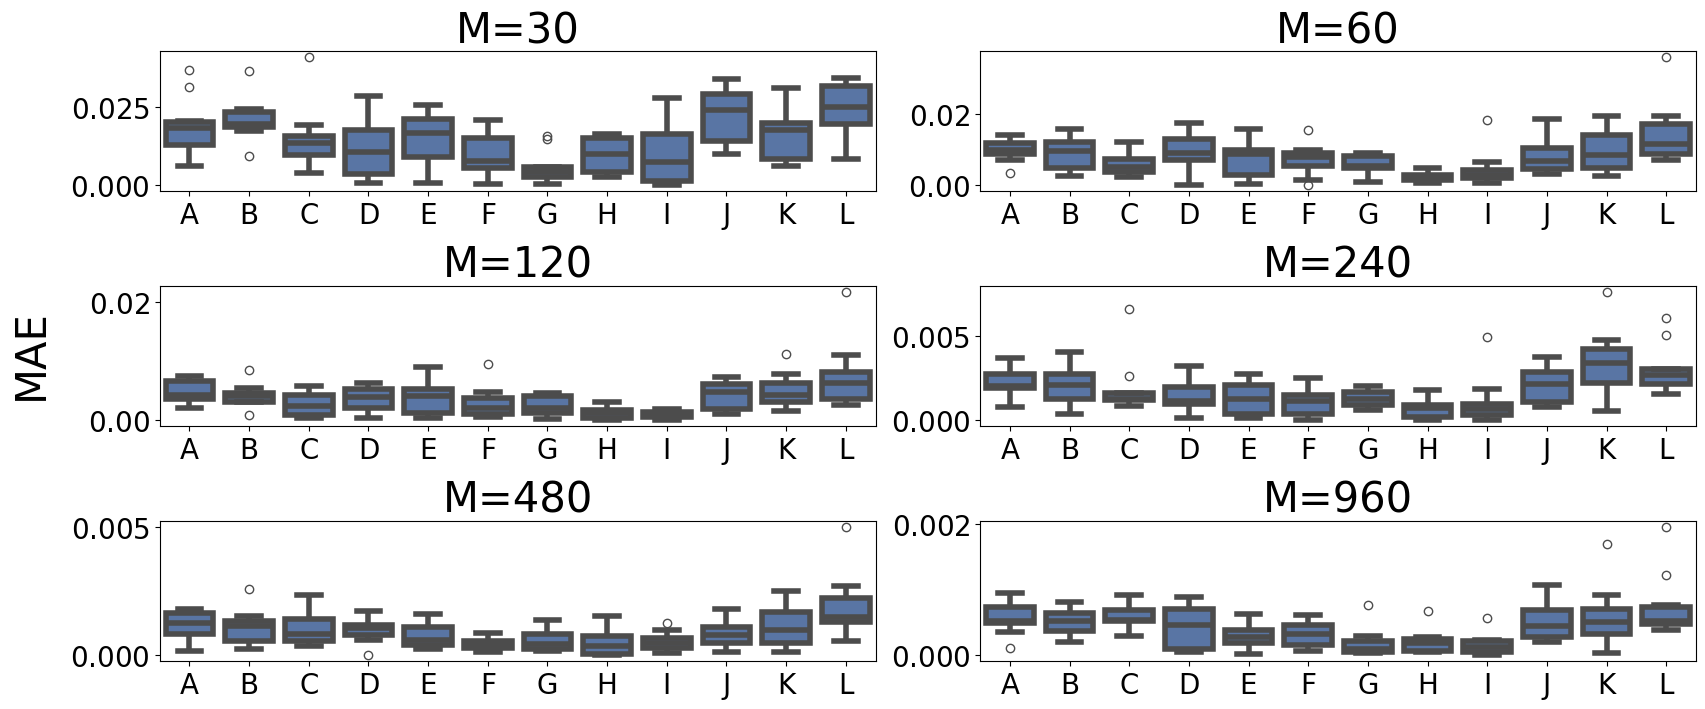

In [81]:
labels = list("ABCDEFGHIJKL")
methods = ["CLOCK", "FIFO"]
wkls = ["IRM", "HE"]
pairs = list(itertools.product(wkls, methods, alphas))

sns.set_palette("deep")
font_axes = 30
font_ticks = 20
line_width = 4
palette = sns.color_palette("deep", len(labels))
color_map = dict(zip(labels, palette))

mapping = {pk: lab for pk, lab in zip(pairs, labels)}
order = labels

df_plot = df_err.copy()
df_plot["method_param"] = list(zip(df_plot.workload, df_plot.method, df_plot.alpha))
df_plot["short"] = df_plot["method_param"].map(mapping)

M_list = [30, 60, 120, 240, 480, 960]
n_list = [n]

subplot_rows, subplot_cols = 3, 2
fig2, axes2 = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 8),
                           sharex=False, sharey=False)
axes_flat = axes2.flatten()

for ax2, (M, n_val) in zip(axes_flat, itertools.product(M_list, n_list)):
    cell = df_plot[(df_plot.m == M) & (df_plot.n == n_val)].copy()
    sns.boxplot(x='short', y='error', data=cell, ax=ax2,
                linewidth=line_width, order=order)
    ax2.set_title(f"M={M}", fontsize=font_axes)
    ax2.tick_params(labelsize=font_ticks)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0)

fig2.text(0.025, 0.5, 'MAE', va='center', rotation='vertical',
          fontsize=font_axes)

plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
plt.savefig("fifo-clock-maes.pdf", format='pdf')
plt.show()


In [9]:
# hot/cold
r = 0.8
f = 0.2
M = 10000
lh = r / f / M
lc = (1 - r) / (1 - f) / M
lmb = [lh, lc]


In [8]:
# CLOCK IRM:

def clock_irm_hc(f,m,r,tc):
    lambdaH = r/(f*m)
    lambdaC = (1-r)/((1-f)*m)
    Ch = symbols('Ch')
    Cc = symbols('Cc')
    solution = solve(((1-(1/(1+(lambdaH*tc/exp(-lambdaH*tc))))-Ch/f/m), 1-(1/(1+(lambdaC*tc/exp(-lambdaC*tc))))-Cc/((1-f)*m)),Cc,Ch)
    c = solution[Cc]+solution[Ch]
    phit = r*solution[Ch]/f/m + (1-r)*solution[Cc]/(1-f)/m
    return int(c), phit

# CLOCK HE:

def fh(h,lh,lc,t):
    return (exp(-(lh*t) - lc*r*t + lh*r*t)*(-(h*lh) + lc*r - exp((lh + lc*r - lh*r)*t)*lc*r - h*lc*r + h*lh*r))/(-lh - lc*r + lh*r)

def pha0(pp,lh,lc,tc):
    return (pp*exp(-lh*tc))

def pca0(pp,lh,lc,tc):
    return ((1-pp)*exp(-lc*tc))

def pha1(pp,lh,lc,t):#solved with the 4-state differential equation
    denominator = -lh - lc * r + lh * r
    exponential_term = exp((lh * (-1 + r) - lc * r) * t)
    expression_term = (pp * lh - exp((lc - lh) * r * t) * pp * lh - lc * r + exp(lh * t + (lc - lh) * r * t) * lc * r + pp * lc * r - exp((lc - lh) * r * t) * pp * lc * r - pp * lh * r + exp((lc - lh) * r * t) * pp * lh * r)
    return -(1 / denominator) * exponential_term * expression_term

def pca1(pp,lh,lc,tc):
    return 1-pha0(pp,lh,lc,tc)-pca0(pp,lh,lc,tc)-pha1(pp,lh,lc,tc)

def ph_after_evict(pp,lh,lc,tc):
    return pha1(pp,lh,lc,tc)/(pha1(pp,lh,lc,tc)+pca1(pp,lh,lc,tc))

def pevict(pp,lh,lc,tc):
    return pha0(pp,lh,lc,tc)+pca0(pp,lh,lc,tc)

def p_recycle(pp,lh,lc,tc):
    return pha1(pp,lh,lc,tc)+pca1(pp,lh,lc,tc)

def num_renewals(h, lh, lc, tc):
    integrand = lambda t: lh*fh(h,lh,lc,t) + lc*(1 - fh(h,lh,lc,t))
    val, err = quad(integrand, 0, tc)
    return val

def Occupancy(r, lh, lc, tc):
    eps = 1e-5
    pp = r
    R  = 1.0
    O  = R
    hits = 0.0
    while R >= eps:
        renewals = num_renewals(pp, lh, lc, tc)
        hits    += R * renewals
        R  *= p_recycle(pp, lh, lc, tc)
        O  += R
        pp  = ph_after_evict(pp, lh, lc, tc)
    return O, hits

def clock_he_hc(f,M,r,tc):
    lmdh = r/(f*M)
    lmdc = (1-r)/((1-f)*M)
    O, hits = Occupancy(r,lmdh,lmdc,tc)
    pmiss = 1/(hits+1)
    c = tc * O * pmiss
    return int(c), 1-pmiss

# FIFO IRM:

def fifo_irm_hc(f,m,r,tc):
    lambdaH = r/(f*m)
    lambdaC = (1-r)/((1-f)*m)
    C = symbols('C')
    phmiss = 1/(1+lambdaH*tc)
    pcmiss = 1/(1+lambdaC*tc)
    pmiss = r*phmiss+(1-r)*pcmiss
    solution = solve((C - tc*pmiss),C)[0]
    phit = 1-pmiss
    return int(solution), phit

# FIFO HE:

def fifo_he_hc(f, m, r, tc):
    N_t = lambda t: (-(f - r)**2 + (f - r)**2/np.exp(((-1 + r)*r*t)/((-1 + f)*f*m)) + ((-1 + r)*r*t)/m)/((-1 + r)*r)
    pmiss = 1 / (1 + N_t(tc))
    phit = 1 - pmiss
    c = tc * pmiss
    return int(c), phit

# Trace gen

def gen_from_irm_hc(r, f, M, n):
    trc = np.zeros(n, dtype=np.int32)
    for i in range(n):
        if np.random.random() < r:
            trc[i] = np.random.randint(0, int(f*M))
        else:
            trc[i] = np.random.randint(int(f*M), M)
    return trc

def gen_from_he_hc(r,f,M,n):
    h = []
    for i in range(M):
        if np.random.random() < r:
            t = np.random.exponential(1/(r/(f*M)))
        else:
            t = np.random.exponential(1/((1-r)/((1-f)*M)))
        heapq.heappush(h, [t,i])        
    a = []
    for i in range(n):
        t0,addr = h[0]
        a.append(addr)
        if np.random.random() < r:
            t = np.random.exponential(1/(r/(f*M)))
        else:
            t = np.random.exponential(1/((1-r)/((1-f)*M)))
        heapq.heapreplace(h, [t0+t,addr])
    return np.array(a, dtype=np.int32)

In [10]:
ms = [1000, 10000] # H/C has algorithmic cost constant in M
n = 10000000
f = 0.2        
r = 0.8

records_hc = []
errors_hc = []

for M in ms:
    trc_irm_hc = gen_from_irm_hc(r, f, M, n)
    trc_he_hc = gen_from_he_hc(r, f, M, n)

    taus = gen_taus(M * 2, 10, power=0.8)

    for tc in taus:
        cc_c_irm_pred, cc_hr_irm_pred = clock_irm_hc(f, M, r, tc)
        cc_hr_irm_sim = tg.sim_clock(int(cc_c_irm_pred), trc_irm_hc, raw=True, K=1)

        f_c_irm_pred, fc_hr_irm_pred = fifo_irm_hc(f, M, r, tc)
        fc_hr_irm_sim = tg.sim_fifo(int(f_c_irm_pred), trc_irm_hc, raw=True)

        cc_c_he_pred, cc_hr_he_pred = clock_he_hc(f, M, r, tc)
        cc_hr_he_sim = tg.sim_clock(int(cc_c_he_pred), trc_he_hc, raw=True, K=1)

        fc_c_he_pred, fc_hr_he_pred = fifo_he_hc(f, M, r, tc)
        fc_hr_he_sim = tg.sim_fifo(int(fc_c_he_pred), trc_he_hc, raw=True)

        records_hc.extend([
            {"m": M, "n": n, "tau": tc,
             "workload": "IRM", "method": "K=1",
             "C_pred": cc_c_irm_pred, "hr_pred": cc_hr_irm_pred, "hr_sim": cc_hr_irm_sim},
            {"m": M, "n": n, "tau": tc,
             "workload": "IRM", "method": "K=0",
             "C_pred": f_c_irm_pred, "hr_pred": fc_hr_irm_pred, "hr_sim": fc_hr_irm_sim},
            {"m": M, "n": n, "tau": tc,
             "workload": "HE", "method": "K=1",
             "C_pred": cc_c_he_pred, "hr_pred": cc_hr_he_pred, "hr_sim": cc_hr_he_sim},
            {"m": M, "n": n, "tau": tc,
             "workload": "HE", "method": "K=0",
             "C_pred": float(fc_c_he_pred), "hr_pred": float(fc_hr_he_pred), "hr_sim": fc_hr_he_sim},
        ])

        errors_hc.extend([
            {"m": M, "n": n, "tau": tc,
             "workload": "IRM", "method": "K=1",
             "error": abs(cc_hr_irm_pred - cc_hr_irm_sim)},
            {"m": M, "n": n, "tau": tc,
             "workload": "IRM", "method": "K=0",
             "error": abs(fc_hr_irm_pred - fc_hr_irm_sim)},
            {"m": M, "n": n, "tau": tc,
             "workload": "HE", "method": "K=1",
             "error": abs(cc_hr_he_pred - cc_hr_he_sim)},
            {"m": M, "n": n, "tau": tc,
             "workload": "HE", "method": "K=0",
             "error": abs(fc_hr_he_pred - fc_hr_he_sim)},
        ])

df_hc = pd.DataFrame(records_hc)
df_err_hc = pd.DataFrame(errors_hc)


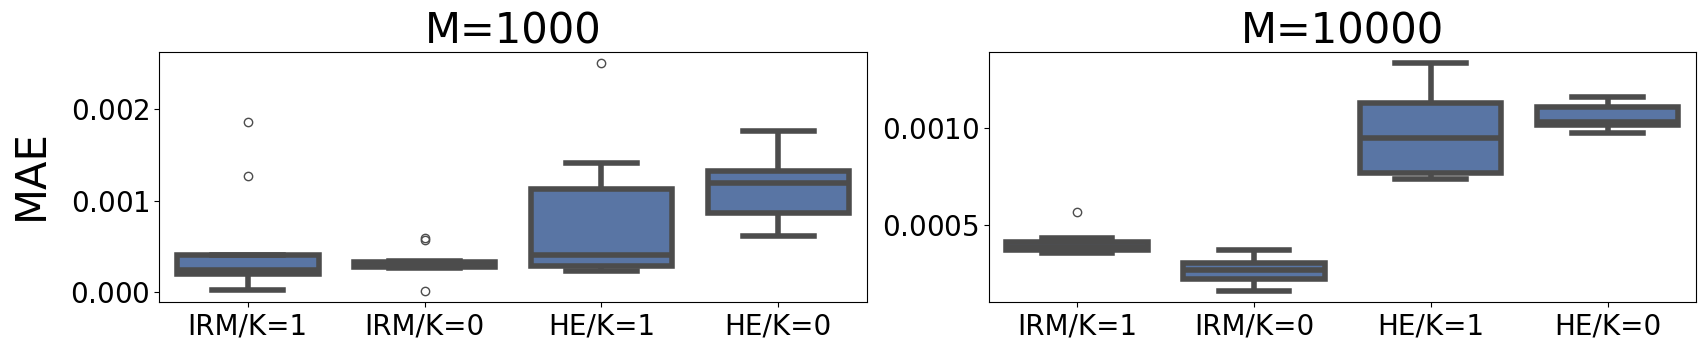

In [26]:
labels = ["IRM/K=1", "IRM/K=0", "HE/K=1", "HE/K=0"]
methods = ["K=1", "K=0"]
wkls = ["IRM", "HE"]
pairs = list(itertools.product(wkls, methods))  # IRM/K=1, IRM/K=0, HE/K=1, HE/K=0
mapping = dict(zip(pairs, labels))

_df = df_err_hc.copy()
_df["error"] = _df["error"].astype(str).str.strip()
_df["error"] = pd.to_numeric(_df["error"], errors="coerce")
_df = _df.dropna(subset=["error"])
_df["workload"] = _df["workload"].astype(str).str.strip()
_df["method"] = _df["method"].astype(str).str.strip()
_df["method_param"] = list(zip(_df.workload, _df.method))
_df["short"] = _df["method_param"].map(mapping)
_df["short"] = pd.Categorical(_df["short"], categories=labels, ordered=True)
order = labels

subplot_rows, subplot_cols = 1, 2
fig2, axes2 = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 4),
                           sharex=False, sharey=False)
axes_flat = axes2.flatten()

for ax2, (M, n_val) in zip(axes_flat, itertools.product(ms, [n])):
    cell = _df[(_df.m == M) & (_df.n == n_val)].copy()
    sns.boxplot(x='short', y='error', data=cell, ax=ax2,
                linewidth=4, order=order)
    ax2.set_title(f"M={M}", fontsize=30)
    ax2.tick_params(labelsize=20)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax2.set_xticks(range(len(order)))
    ax2.set_xticklabels(order, fontsize=20, rotation=0)

fig2.text(0.025, 0.5, 'MAE', va='center', rotation='vertical',
          fontsize=30)

plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
plt.savefig("fifo-clock-maes-hc.pdf", format='pdf')
plt.show()


In [12]:
# REN

def _solve(r, xh, mh, tc):
    lc = 1 - r
    mh_tc = np.interp(tc, xh, mh)
    phmiss = 1 / (1 + mh_tc)
    pcmiss = 1
    ch = phmiss * tc * r
    cc = lc * tc
    c = ch + cc
    pmiss = r * phmiss + lc * pcmiss
    return int(c), 1 - pmiss


def _mc_renewal(f, t_max, n_bins, n):
    m = np.zeros(n_bins, dtype=int)
    for _ in range(n):
        t = 0
        while True:
            dt = f()
            t += dt
            if dt == -1 or t >= t_max:
                break
            idx = int(n_bins * t / t_max)
            m[idx] += 1
    return np.cumsum(m / n)


def _forward_iad(trace):
    trace2 = np.array(np.flip(trace))
    iads = tg.iad2.iad(trace2)
    return np.flip(iads)


def _normalize_trace(trace):
    trace = np.asarray(trace)
    if trace.ndim == 2:
        # Assume (size, addr) in bytes; convert to cache-line address stream.
        trace = trace.copy()
        trace[:, 0] += 7
        trace = tg.squash(tg.unroll(trace // 8))
        trace = np.asarray(trace)
    elif trace.ndim != 1:
        raise ValueError(f"trace must be 1D or (N,2); got shape {trace.shape}")
    return trace


def _adj_iad(trace):
    trace = _normalize_trace(trace)
    addrs, counts = np.unique(trace, return_counts=True)
    skip = np.zeros(np.max(addrs) + 1, dtype=bool)
    skip[addrs[counts > 1]] = True

    good = np.zeros(len(trace), dtype=bool)
    for j, addr in enumerate(trace):
        if skip[addr]:
            skip[addr] = False
        else:
            good[j] = True

    iads = _forward_iad(trace)
    return iads[good]


def _trunk_iad(trace, size):
    iads = _adj_iad(trace)
    return [iads[i:i + size] for i in range(0, len(iads), size)]


def _cc(iads):
    r = np.sum(iads > -1) / len(iads)
    t_max = len(iads) * 50
    iads = iads[iads > -1]

    mh = _mc_renewal(lambda: np.random.choice(iads), t_max, 3000, 50000)
    print(".")

    xh = np.arange(0, t_max, t_max / 3000)
    phits_model = []
    c1 = []
    for tc in range(0, t_max, 3000):
        c_model, phit_model = _solve(r, xh, mh, tc)
        c1.append(c_model)
        phits_model.append(phit_model)
    return c1, phits_model


def trunk_avg(full_trace, size):
    trunks = _trunk_iad(full_trace, size)
    c, phits = [], []
    for iads in trunks:
        c1, phits_model = _cc(iads)
        c.append(c1)
        phits.append(phits_model)
    c_avg = [sum(sublist) / len(sublist) for sublist in zip(*c)]
    phits_avg = [sum(sublist) / len(sublist) for sublist in zip(*phits)]
    return c_avg, phits_avg


In [15]:
w26 = np.load('../data/w26.npy')
w26[:, 0] += 7
w26 = tg.squash(tg.unroll(w26 // 8))

c_avg_w26, phits_avg_w26 = trunk_avg(w26, size = 400000)


.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


In [ ]:
# np.save("/opt/traces/w26/fifo_c_avg_w26", c_avg_w26)
# np.save("/opt/traces/w26/fifo_phits_avg_w26", phits_avg_w26)

# c_avg_w26 = np.load("../data/FIFO/fifo_c_avg_w26.npy")
# phits_avg_w26 = np.load("../data/FIFO//fifo_phits_avg_w26.npy")

# c_, phits_sim, phits_model = [],[],[]
# for i in range(0, len(c_avg_w26),100):
#     phit= tg.sim_fifo(int(c_avg_w26[i]), w26, raw=True)
#     c_.append(c_avg_w26[i])
#     phits_sim.append(phit)
#     phits_model.append(phits_avg_w26[i])
    
# np.save("../data/FIFO/fifo_c_avg_w26.npy", c_)
# np.save("../data/FIFO/fifo_sim_phits_w26.npy", phits_sim)
# np.save("../data/FIFO/fifo_model_phits_w26.npy", phits_model)


In [23]:
w07 = np.load('../data/w07.npy')
w07 = w07[:len(w07)*3//8]
c_avg_w07, phits_avg_w07 = trunk_avg(w07,size=400000)

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


In [27]:
c_w07, phits_sim_w07, phits_model_w07 = [],[],[]
for i in range(0, len(c_avg_w07),100):
    phit= tg.sim_fifo(int(c_avg_w07[i]), w07, raw = True)
    c_w07.append(c_avg_w07[i])
    phits_sim_w07.append(phit)
    phits_model_w07.append(phits_avg_w07[i])

# np.save('data/FIFO/FIFO_phits_w07_prediction.npy', phits_model_w07, allow_pickle=True)
# np.save('data/FIFO/FIFO_phits_w07_simulation.npy', phits_sim_w07, allow_pickle=True)
# np.save('data/FIFO/FIFO_cachesizes_w07.npy', c_w07, allow_pickle=True)

In [13]:
phits_model_w07 = np.load('../data/FIFO/FIFO_phits_w07_prediction.npy')
phits_sim_w07 = np.load('../data/FIFO/FIFO_phits_w07_simulation.npy')
c_w07 = np.load('../data/FIFO/FIFO_cachesizes_w07.npy')

In [14]:

def mc_clock(trace):
    items,counts = np.unique(trace,return_counts=True)
    rev = np.array(trace[::-1],dtype=np.int32)
    irt = tg.iad(rev)
    irt = irt[::-1]
    ii = irt[irt>-1]
    n1 = np.sum(counts==1)
    ii = np.append(ii, np.ones(n1)*-1)
    def t_ii():
        return np.random.choice(ii)
    def MC_clock(f, tc, N):
        hits,misses,passes = 0,0,0
        for i in range(N):
            t = 0
            misses += 1
            passes += 1
            next =tc 
            _t = f()
            if _t == -1 or _t > next:
                continue
            t += _t
            hits += 1
            while True:
                _t = t_ii()
                if _t == -1:
                    break
                t += _t
                if t > next+tc:
                    break
                hits += 1
                if t > next:
                    next +=tc 
                    passes += 1
        ph = hits/(hits+misses)
        pm = 1-ph
        np = passes/N
        _C = np * tc * pm
        return ph,_C,np
    rs = np.sum(counts==1) / len(trace)
    hot = items[counts>20]
    hot_i = np.zeros(np.max(items)+1)
    for i in hot:
        hot_i[i] = True
    hot_a = np.array(hot_i[trace],dtype=bool)
    iad_hot = irt[hot_a]
    # iad_hot = iad_hot[iad_hot>-1]
    iad_cold = irt[np.logical_not(hot_a)]
    # iad_cold = iad_cold[iad_cold>-1]
    def t_hot():
        return np.random.choice(iad_hot)
    def t_cold():
        return np.random.choice(iad_cold)  
    tc = np.arange(100000,4000000,50000)
    # hr_sim = [sim_clock(_tc,trace) for _tc in tc]
    aa_hot = np.array([MC_clock(t_hot, _tc, 100000) for _tc in tc])
    aa_cold = np.array([MC_clock(t_cold, _tc, 100000) for _tc in tc])
    rh = np.sum(hot_a) / len(trace)
    rc = 1 - rs - rh
    #3 freq classes
    _C = tc*rs + aa_hot[:,1]*rh + aa_cold[:,1]*rc
    _hr = aa_hot[:,0]*rh + aa_cold[:,0]*rc
    return _C, _hr


In [18]:
# w26 = np.loadtxt('/mnt/oldssd/opt/traces/w26_r.txt',dtype=np.int32)
# w26[:,0] += 7
# w26 = tg.squash(tg.unroll(w26//8))

# c_cc_w26, hr_cc_w26 = mc_clock(w26)
# hr_w26_sim = [tg.sim_clock(int(c_),w26, raw=True) for c_ in c_cc_w26]

# np.save('../data/CLOCK/CLOCK_phits_w26_prediction.npy',hr_cc_w26)
# np.save('../data/CLOCK/CLOCK_c_w26_prediction.npy',c_cc_w26)
# np.save('../data/CLOCK/CLOCK_phits_w26_simulation.npy',hr_w26_sim)
c26 = np.load('../data/CLOCK/CLOCK_c_w26_prediction.npy')
hr26_pred = np.load('../data/CLOCK/CLOCK_phits_w26_prediction.npy')
hr26_sim = np.load('../data/CLOCK/CLOCK_phits_w26_simulation.npy')


In [39]:
w07 = np.load('../data/w07.npy')
w07 = w07[:len(w07)*3//8]
c_cc_w07, hr_cc_w07 = mc_clock(w07)
hr_w07_sim = [tg.sim_clock(int(c_),w07, raw=True) for c_ in c_cc_w07]

In [21]:
# np.save('../data/CLOCK/CLOCK_phits_w07_prediction.npy',hr_cc_w07)
# np.save('../data/CLOCK/CLOCK_c_w07_prediction.npy',c_cc_w07)
# np.save('../data/CLOCK/CLOCK_phits_w07_simulation.npy',hr_w07_sim)

c07 = np.load('../data/CLOCK/CLOCK_c_w07_prediction.npy')
hr_w07_pred = np.load('../data/CLOCK/CLOCK_phits_w07_prediction.npy')
hr_w07_sim = np.load('../data/CLOCK/CLOCK_phits_w07_simulation.npy')

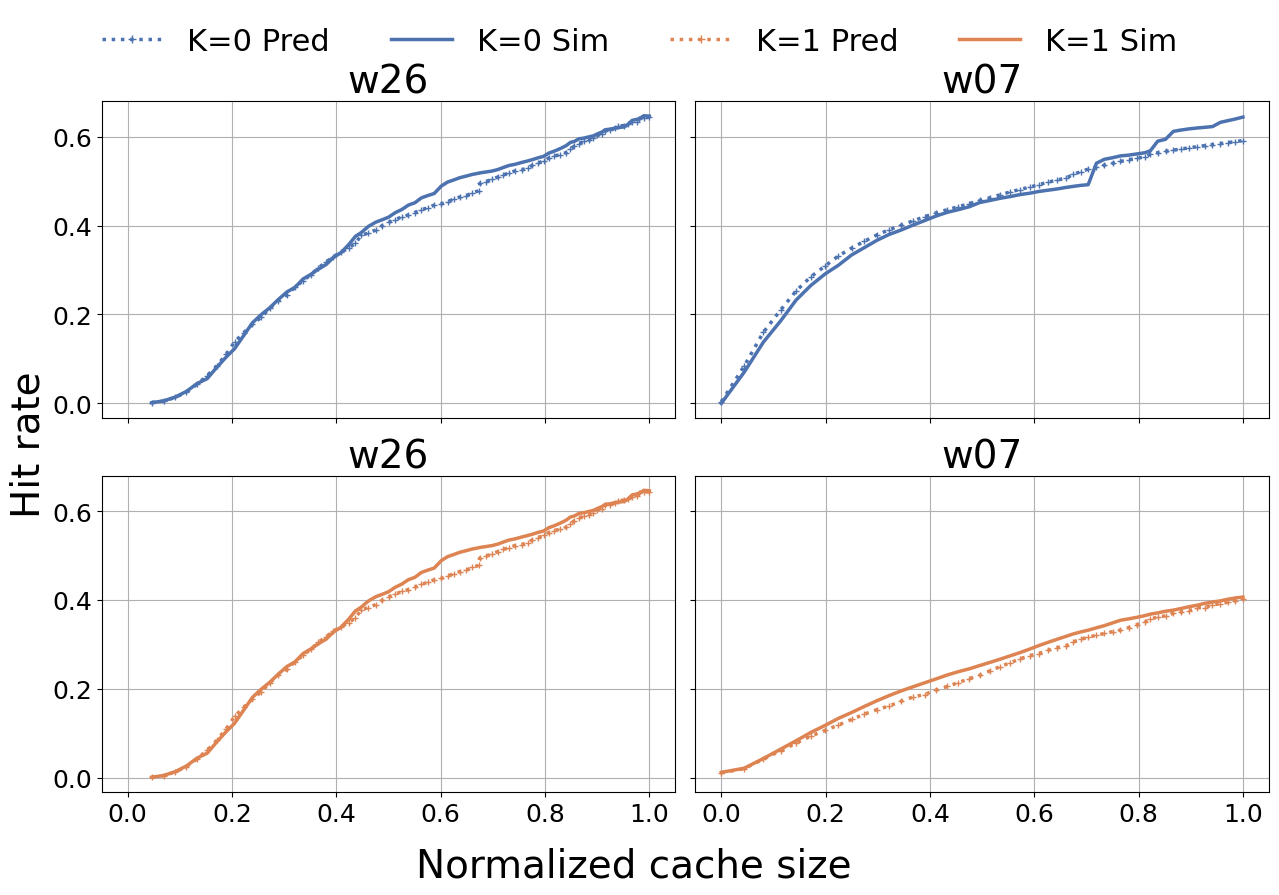

In [25]:

fig, axs = plt.subplots(2, 2, figsize=(13, 9), sharex=True, sharey=True)

fifo_color = palette[0]
clock_color = palette[1]

def _norm_xy(c, y_pred, y_sim):
    n = min(len(c), len(y_pred), len(y_sim))
    c_n = c[:n]
    x = c_n / np.max(c_n)
    return x, y_pred[:n], y_sim[:n]

# FIFO w26
ax = axs[0, 0]
x, y_pred, y_sim = _norm_xy(c26, hr26_pred, hr26_sim)
ax.plot(x, y_pred, linestyle=':', marker='+', markersize=4, linewidth=2.5, color=fifo_color, label='K=0 Pred')
ax.plot(x, y_sim, linestyle='-', linewidth=2.5, color=fifo_color, label='K=0 Sim')
ax.set_title('w26', fontsize=28)
ax.grid(True)

# FIFO w07
ax = axs[0, 1]
x, y_pred, y_sim = _norm_xy(c_w07, phits_model_w07, phits_sim_w07)
ax.plot(x, y_pred, linestyle=':', marker='+', markersize=4, linewidth=2.5, color=fifo_color, label='K=0 Pred')
ax.plot(x, y_sim, linestyle='-', linewidth=2.5, color=fifo_color, label='K=0 Sim')
ax.set_title('w07', fontsize=28)
ax.grid(True)

# CLOCK w26
ax = axs[1, 0]
x, y_pred, y_sim = _norm_xy(c26, hr26_pred, hr26_sim)
ax.plot(x, y_pred, linestyle=':', marker='+', markersize=4, linewidth=2.5, color=clock_color, label='K=1 Pred')
ax.plot(x, y_sim, linestyle='-', linewidth=2.5, color=clock_color, label='K=1 Sim')
ax.set_title('w26', fontsize=28)
ax.grid(True)

# CLOCK w07
ax = axs[1, 1]
x, y_pred, y_sim = _norm_xy(c_w07, hr_w07_pred, hr_w07_sim)
ax.plot(x, y_pred, linestyle=':', marker='+', markersize=4, linewidth=2.5, color=clock_color, label='K=1 Pred')
ax.plot(x, y_sim, linestyle='-', linewidth=2.5, color=clock_color, label='K=1 Sim')
ax.set_title('w07', fontsize=28)
ax.grid(True)

for ax in axs.flat:
    ax.tick_params(axis='both', labelsize=18)

fig.supxlabel('Normalized cache size', fontsize=28)
fig.supylabel('Hit rate', fontsize=28)

from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color=fifo_color, linestyle=':', marker='+', linewidth=2.5, label='K=0 Pred'),
    Line2D([0], [0], color=fifo_color, linestyle='-', linewidth=2.5, label='K=0 Sim'),
    Line2D([0], [0], color=clock_color, linestyle=':', marker='+', linewidth=2.5, label='K=1 Pred'),
    Line2D([0], [0], color=clock_color, linestyle='-', linewidth=2.5, label='K=1 Sim'),
]
fig.legend(handles=legend_handles, loc='upper center', ncol=4, fontsize=22, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.savefig('figures/real-pred.pdf', format='pdf', bbox_inches='tight')
plt.show()


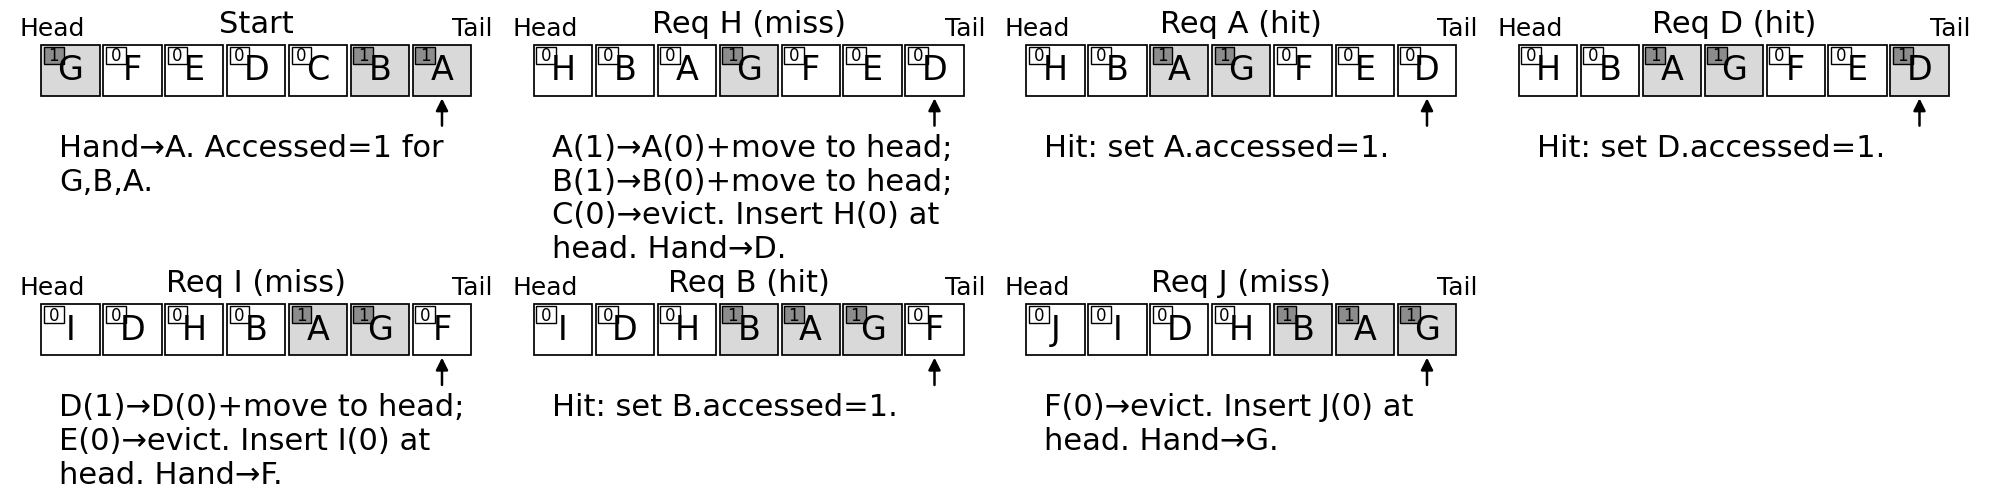

In [27]:
from matplotlib.patches import Rectangle, FancyArrowPatch

panels = [
    {"title":"Start","queue":list("GFEDCBA"),"visited_ones":{"G","B","A"},"hand":"A",
     "note":"Hand→A. Accessed=1 for G,B,A."},

    {"title":"Req H (miss)","queue":list("HBAGFED"),"visited_ones":{"G"},"hand":"D",
     "note":"A(1)→A(0)+move to head; B(1)→B(0)+move to head; C(0)→evict. Insert H(0) at head. Hand→D."},

    {"title":"Req A (hit)","queue":list("HBAGFED"),"visited_ones":{"G","A"},"hand":"D",
     "note":"Hit: set A.accessed=1."},

    {"title":"Req D (hit)","queue":list("HBAGFED"),"visited_ones":{"G","A","D"},"hand":"D",
     "note":"Hit: set D.accessed=1."},

    {"title":"Req I (miss)","queue":list("IDHBAGF"),"visited_ones":{"G","A"},"hand":"F",
     "note":"D(1)→D(0)+move to head; E(0)→evict. Insert I(0) at head. Hand→F."},

    {"title":"Req B (hit)","queue":list("IDHBAGF"),"visited_ones":{"G","A","B"},"hand":"F",
     "note":"Hit: set B.accessed=1."},

    {"title":"Req J (miss)","queue":list("JIDHBAG"),"visited_ones":{"G","A","B"},"hand":"G",
     "note":"F(0)→evict. Insert J(0) at head. Hand→G."},
]

FS_TITLE = 22
FS_HEADTAIL = 18
FS_ITEM = 24
FS_BIT = 12
FS_HAND = 18
FS_NOTE = 22
FS_SCAN = 13

def draw_queue(ax, queue, visited_ones, hand_item):
    ax.set_axis_off()
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 3)

    ax.text(0.2, 2.8, "Head", fontsize=FS_HEADTAIL, ha="left", va="center")
    ax.text(9.8, 2.8, "Tail", fontsize=FS_HEADTAIL, ha="right", va="center")

    n = len(queue)
    x0, y0 = 0.6, 1.2
    track = 8.8

    # ---- knobs ----
    gap_frac = 0.06      # fraction of each slot reserved as gap (increase => more gap)
    H = 1.2            # object rectangle height (increase => taller)
    bit_frac = 0.34      # bit size as fraction of rect width (increase => larger bit)
    bit_pad = 0.05       # padding inside rect for the bit (decrease => closer to corner)
    # --------------

    W = track / n                    # slot width (including gap)
    rect_w = W * (1 - gap_frac)      # actual drawn rectangle width
    dx_gap = W - rect_w              # gap in data units

    for i, item in enumerate(queue):
        x = x0 + i * W + dx_gap/2    # center the rect in its slot
        v = 1 if item in visited_ones else 0
        face = "0.85" if v else "white"

        # bigger object rect + gap between rects
        rect = Rectangle((x, y0), rect_w, H, linewidth=1.25,
                         edgecolor="black", facecolor=face)
        ax.add_patch(rect)
        ax.text(x + rect_w/2, y0 + H/2, item, fontsize=FS_ITEM, ha="center", va="center")

        # bigger bit box (based on rect width)
        bit_s = rect_w * bit_frac
        bx = x + bit_pad
        by = y0 + H - bit_s - bit_pad
        bit_face = "0.55" if v else "white"
        bit = Rectangle((bx, by), bit_s, bit_s, linewidth=1.0,
                        edgecolor="black", facecolor=bit_face)
        ax.add_patch(bit)
        ax.text(bx + bit_s/2, by + bit_s/2, str(v),
                fontsize=FS_BIT, ha="center", va="center")

        if item == hand_item:
            cx = x + rect_w/2
            arrow = FancyArrowPatch((cx, y0 - 0.78), (cx, y0),
                                    arrowstyle='-|>', mutation_scale=18,
                                    linewidth=1.8, color="black")
            ax.add_patch(arrow)

fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(2, 4, wspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(7)]

import textwrap

for ax, p in zip(axes, panels):
    ax.set_title(p["title"], fontsize=FS_TITLE, y=0.9, pad=0)
    draw_queue(ax, p["queue"], p["visited_ones"], p["hand"])
    note = textwrap.fill(p["note"], width=28)
    ax.text(0.1, 0.1, note, transform=ax.transAxes,
            fontsize=FS_NOTE, ha="left", va="top")


plt.tight_layout()
# fig.savefig("sieve_example_static_diagram_bigfont.png", dpi=220, bbox_inches="tight")
# fig.savefig("sieve_example_static_diagram_bigfont.svg", bbox_inches="tight")
fig.savefig("figures/fifo_second_chance.pdf", bbox_inches="tight", format='pdf')
plt.show()
plt.close(fig)

/tmp/ipykernel_3386661/3250990413.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


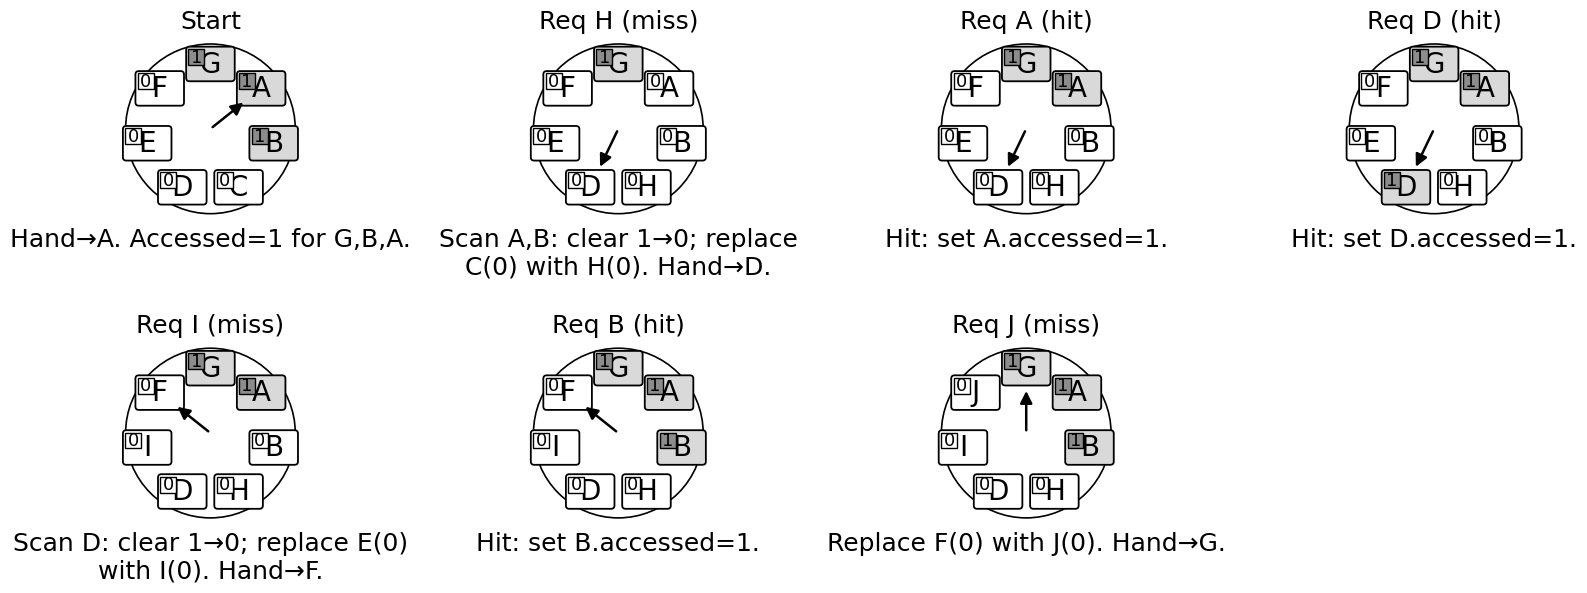

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle, FancyArrowPatch
import textwrap

panels = [
    {"title":"Start","queue":list("GFEDCBA"),"visited_ones":{"G","B","A"},"hand":"A",
     "note":"Hand→A. Accessed=1 for G,B,A."},
    {"title":"Req H (miss)","queue":list("GFEDHBA"),"visited_ones":{"G"},"hand":"D",
     "note":"Scan A,B: clear 1→0; replace C(0) with H(0). Hand→D."},
    {"title":"Req A (hit)","queue":list("GFEDHBA"),"visited_ones":{"G","A"},"hand":"D",
     "note":"Hit: set A.accessed=1."},
    {"title":"Req D (hit)","queue":list("GFEDHBA"),"visited_ones":{"G","A","D"},"hand":"D",
     "note":"Hit: set D.accessed=1."},
    {"title":"Req I (miss)","queue":list("GFIDHBA"),"visited_ones":{"G","A"},"hand":"F",
     "note":"Scan D: clear 1→0; replace E(0) with I(0). Hand→F."},
    {"title":"Req B (hit)","queue":list("GFIDHBA"),"visited_ones":{"G","A","B"},"hand":"F",
     "note":"Hit: set B.accessed=1."},
    {"title":"Req J (miss)","queue":list("GJIDHBA"),"visited_ones":{"G","A","B"},"hand":"G",
     "note":"Replace F(0) with J(0). Hand→G."},
]

FS_TITLE=18; FS_ITEM=20; FS_BIT=13; FS_HAND=16; FS_NOTE=18; FS_IDX=11

def _slot_centers(n, r=1.95, start_deg=90.0):
    ang = np.deg2rad(start_deg) + 2*np.pi*np.arange(n)/n
    return r*np.cos(ang), r*np.sin(ang), ang

def draw_clock_circle(ax, queue, visited_ones, hand_item):
    ax.set_aspect("equal")
    ax.set_axis_off()
    n = len(queue)
    xs, ys, ang = _slot_centers(n)

    # extra space below for notes
    ax.set_xlim(-2.9, 2.9)
    ax.set_ylim(-3.0, 2.9)

    # larger slot frames
    box_w, box_h = 1.42, 1
    bit_s = 0.32

    ring_r = 2.55
    ax.add_patch(plt.Circle((0,0), ring_r, fill=False, linewidth=1.2, color="black", zorder=0))

    for i, (item, x, y) in enumerate(zip(queue, xs, ys)):
        v = 1 if item in visited_ones else 0
        face = "0.85" if v else "white"

        rect = FancyBboxPatch((x-box_w/2, y-box_h/2), box_w, box_h,
                              boxstyle="round,pad=0.02,rounding_size=0.10",
                              linewidth=1.3, edgecolor="black", facecolor=face, zorder=2)
        ax.add_patch(rect)
        ax.text(x, y, item, fontsize=FS_ITEM, ha="center", va="center", zorder=3)

        bit_box = bit_s * 1.5 # arger frame
        bx = x - box_w/2 + 0.05
        by = y + box_h/2 - bit_box - 0.05
        bit_face = "0.55" if v else "white"

        ax.add_patch(Rectangle((bx,by), bit_box, bit_box, linewidth=1.0,
                            edgecolor="black", facecolor=bit_face, zorder=3))
        ax.text(bx+bit_box/2, by+bit_box/2, str(v), fontsize=FS_BIT,
                ha="center", va="center", zorder=4)

        if item == hand_item:
            endx = 1.35*np.cos(ang[i])
            endy = 1.35*np.sin(ang[i])
            ax.add_patch(FancyArrowPatch((0,0), (endx,endy),
                                         arrowstyle='-|>', mutation_scale=18,
                                         linewidth=1.8, color="black", zorder=5))

fig = plt.figure(figsize=(20,6.5))
gs = fig.add_gridspec(2,4, wspace=0.25, hspace=0.55)
axes = [fig.add_subplot(gs[i]) for i in range(7)]

for ax, p in zip(axes, panels):
    ax.set_title(p["title"], fontsize=FS_TITLE, y=1.02, pad=0)
    draw_clock_circle(ax, p["queue"], p["visited_ones"], p["hand"])
    note = textwrap.fill(p["note"], width=32)
    ax.text(0, -2.95, note, fontsize=FS_NOTE, ha="center", va="top")

plt.tight_layout()
fig.savefig("figures/clock_circular_buffer.pdf", bbox_inches="tight", format="pdf")
plt.show()
plt.close(fig)

In [ ]:
def _p_tauc(x, tail=1e-14, ncap=200000):
    p0 = np.exp(-x)
    if p0 == 0.0:
        p0 = np.finfo(np.float64).tiny
    pmf = [p0]
    s = p0
    n = 0
    while 1.0 - s > tail and n < ncap:
        n += 1
        pmf.append(pmf[-1] * x / n)
        s += pmf[-1]
    return np.asarray(pmf, np.float64), max(0.0, 1.0 - s)

def clock_k_irm_linear(lmb, tc, K, tail=1e-14):
    lam = np.asarray(lmb, np.float64).ravel()
    lam /= lam.sum()
    tc = float(tc)
    K = int(K)
    M = lam.size

    if K == 0:
        pm = float(np.sum(lam / (1.0 + lam * tc)))
        C = int(round(tc * pm))
        return C, 1.0 - pm

    T = np.zeros(M, np.float64)
    one = np.ones(K, np.float64)
    I = np.eye(K, dtype=np.float64)

    for i, li in enumerate(lam):
        x = float(li * tc)
        pmf, tail_mass = _p_tauc(x, tail=tail)

        Q = np.zeros((K, K), np.float64)
        for s in range(K):
            for n, p in enumerate(pmf):
                if s == 0 and n == 0:
                    continue
                lvl = s + n
                nxt = (K - 1) if lvl >= K else max(lvl - 1, 0)
                Q[s, nxt] += p
            if tail_mass:
                Q[s, K - 1] += tail_mass

        A = I - Q
        try:
            t = np.linalg.solve(A, one)
        except np.linalg.LinAlgError:
            eps = np.finfo(np.float64).eps
            t = np.linalg.lstsq(A + eps * I, one, rcond=None)[0]
        T[i] = t[0]

    x = lam * tc
    pm_i = 1.0 / (1.0 + x * T)
    pm = float(np.sum(lam * pm_i))
    occ = float(np.sum(lam * pm_i * T))
    C = int(round(tc * occ))
    return C, 1.0 - pm

def clock_k_he_linear(lmb, tc, K):
    lam = np.asarray(lmb, dtype=np.float64).ravel()
    lam /= lam.sum()
    M = lam.size
    tc = int(tc)
    K = int(K)

    B = np.diag(1.0 - lam)
    U = lam[:, None] * lam[None, :]     # alpha = lam
    Pph = B + U

    if K == 0:
        rho = lam.copy()
        m_tc = 0.0
        for _ in range(tc):
            m_tc += float(rho @ lam)
            rho = rho @ Pph
        pm = 1.0 / (1.0 + m_tc)         # O=1
        C = int(round(tc * pm))
        return C, 1.0 - pm

    N = (K + 1) * M
    blocks = [[np.zeros((M, M), dtype=np.float64) for _ in range(K + 1)] for _ in range(K + 1)]
    for k in range(K):
        blocks[k][k] = B
        blocks[k][k + 1] = U
    blocks[K][K] = B + U
    P = np.block(blocks)

    def _g_tauc(A, n):
        I = np.eye(A.shape[0], dtype=A.dtype)
        if n == 0:
            return I, np.zeros_like(A)
        if n == 1:
            return A, I
        if n % 2 == 0:
            A2, S2 = _g_tauc(A, n // 2)
            return A2 @ A2, S2 + A2 @ S2
        Am, Sm = _g_tauc(A, n - 1)
        return Am @ A, Sm + Am

    Ptc, Ssum = _g_tauc(P, tc)

    g = np.tile(lam, K + 1)

    Nh = K * M
    head = slice(0, Nh)
    tail = slice(M, (K + 1) * M)

    Q = Ptc[head, tail]
    h = (Ssum @ g)[head]

    nu = np.zeros(Nh, dtype=np.float64)
    nu[:M] = lam

    x = np.linalg.solve((np.eye(Nh, dtype=np.float64) - Q).T, nu)
    O = float(x.sum())
    H = float(x @ h)

    pm = 1.0 / (1.0 + H)
    C = int(round(tc * O * pm))
    return C, 1.0 - pm

# It was very slow so I tried pytorch with cuda
import torch

def _pick_device(dtype):
    if torch.backends.cuda.is_available():
        return torch.device("cuda"), dtype
    return torch.device("cpu"), dtype

@torch.no_grad()
def clock_k_he_torch(lmb, tc, K, tol=1e-12, maxit=20000, dtype=torch.float32, device=None):
    if device is None:
        device, dtype = _pick_device(dtype)

    lam = torch.as_tensor(lmb, dtype=dtype, device=device).flatten()
    lam = lam / lam.sum()
    M = int(lam.numel())
    tc = int(tc)
    K = int(K)

    b = 1.0 - lam
    if K == 0:
        B = torch.diag(1.0 - lam)
        U = lam[:, None] * lam[None, :]
        Pph = B + U
        rho = lam.clone()
        m_tc = torch.zeros((), dtype=dtype, device=device)
        for _ in range(tc):
            m_tc = m_tc + (rho @ lam)
            rho = rho @ Pph
        pm = 1.0 / (1.0 + m_tc)
        C = int(torch.round(torch.tensor(tc, device=device, dtype=dtype) * pm).item())
        return C, float((1.0 - pm).item())

    def step_P(y):  # y <- P @ y
        s_next = (y @ lam)  
        out = torch.zeros_like(y)
        for k in range(0, K):
            out[k] = y[k] * b + s_next[k + 1] * lam
        out[K] = y[K] * b + s_next[K] * lam
        return out

    def step_PT(y):  # y <- P^T @ y
        s = (y @ lam)
        out = torch.zeros_like(y)
        out[0] = y[0] * b
        for k in range(1, K):
            out[k] = y[k] * b + s[k - 1] * lam
        out[K] = y[K] * b + s[K] * lam + s[K - 1] * lam
        return out

    # Compute h = (sum_{t=0}^{tc-1} P^t) @ g, then take head levels 0..K-1.
    # g is stacked lam on each level.
    g = lam.expand(K + 1, M).clone()
    cur = g
    acc = torch.zeros_like(g)
    for _ in range(tc):
        acc = acc + cur
        cur = step_P(cur)
    h_head = acc[:K].reshape(-1)

    # Q = P^tc[head, tail], head=levels 0..K-1, tail=levels 1..K
    # For x on head, Q^T x = (P^tc)^T * embed(x on head) restricted to tail.
    def Qt(x_head_flat):
        z = torch.zeros((K + 1, M), dtype=dtype, device=device)
        z[:K] = x_head_flat.view(K, M)
        for _ in range(tc):
            z = step_PT(z)
        return z[1:K + 1].reshape(-1)

    # Solve (I - Q)^T x = nu via fixed-point: x = nu + Q^T x
    nu = torch.zeros(K * M, dtype=dtype, device=device)
    nu[:M] = lam
    x = nu.clone()
    nu_norm = torch.linalg.norm(nu)
    for _ in range(maxit):
        x_new = nu + Qt(x)
        if torch.linalg.norm(x_new - x) <= tol * (nu_norm + 1e-30):
            x = x_new
            break
        x = x_new

    O = x.sum()
    H = x @ h_head

    pm = 1.0 / (1.0 + H)
    C = int(torch.round(torch.tensor(tc, device=device, dtype=dtype) * O * pm).item())
    return C, float((1.0 - pm).item())

In [3]:
m = 960
a = 0.8
n = 10000000
lmb, trc_irm = gen_from_zipf(m, n, a)
trc_he = gen_from_he(m, a, n)

# lam = np.asarray(lmb, dtype=np.float64).ravel()
# # alpha = lam                 
# # T = -np.diag(lam)            
taus = gen_taus(m * 1.5, 10, power=0.95)

# for tc in taus:
#     cc_c_irm_pred_fast, cc_hr_irm_pred_fast = clock_k_irm_linear(lmb, tc, K=3)
#     # cc_c_irm_pred, cc_hr_irm_pred = clock_irm(lmb, tc)
#     cc_hr_irm_sim = tg.sim_clock(int(cc_c_irm_pred_fast), trc_irm, raw=True, K=3)
#     print(f"C_pred_fast={cc_c_irm_pred_fast}, hr_pred={cc_hr_irm_pred_fast}, hr_sim={cc_hr_irm_sim}")
#     print("----")

In [ ]:
for tc in taus:
    cc_c_he_pred_fast, cc_hr_he_pred_fast = clock_k_he_linear(lmb, tc, K=3)
    # cc_c_he_pred, cc_hr_he_pred = fifo_he(lmb, tc)
    cc_hr_he_sim = tg.sim_clock(int(cc_c_he_pred_fast), trc_he, raw=True, K=3)
    print(f"C_pred_fast={cc_c_he_pred_fast}, hr_pred={cc_hr_he_pred_fast}, hr_sim={cc_hr_he_sim}")
    print("----")

C_pred_fast=79, hr_pred=0.44701672755385347, hr_sim=0.4452488
----
C_pred_fast=148, hr_pred=0.6039243575632913, hr_sim=0.6024419999999999
----
C_pred_fast=207, hr_pred=0.7017681717982661, hr_sim=0.7018355000000001
----
C_pred_fast=255, hr_pred=0.770920639814371, hr_sim=0.7699932
----
C_pred_fast=296, hr_pred=0.8216576534135533, hr_sim=0.8215675
----
C_pred_fast=329, hr_pred=0.8601394195619755, hr_sim=0.8597059
----
C_pred_fast=356, hr_pred=0.8892799721186848, hr_sim=0.8888389
----
C_pred_fast=378, hr_pred=0.9115993591376028, hr_sim=0.9113248
----
C_pred_fast=396, hr_pred=0.9290862742553726, hr_sim=0.9289131
----
C_pred_fast=411, hr_pred=0.9428643691442563, hr_sim=0.942924
----


In [11]:
for tc in taus:
    cc_c_irm_pred_fast, cc_hr_irm_pred_fast = clock_k_irm_linear(lmb, tc, K=15)
    # cc_c_irm_pred, cc_hr_irm_pred = clock_irm(lmb, tc)
    cc_hr_irm_sim = tg.sim_clock(int(cc_c_irm_pred_fast), trc_irm, raw=True, K=15)
    print(f"C_pred_fast={cc_c_irm_pred_fast}, hr_pred={cc_hr_irm_pred_fast}, hr_sim={cc_hr_irm_sim}")
    print("----")

C_pred_fast=132, hr_pred=0.4759409726641963, hr_sim=0.4762581
----
C_pred_fast=229, hr_pred=0.598935242734163, hr_sim=0.5992628
----
C_pred_fast=311, hr_pred=0.6754893442738974, hr_sim=0.6758166
----
C_pred_fast=382, hr_pred=0.7308477840295562, hr_sim=0.7307570999999999
----
C_pred_fast=446, hr_pred=0.7737489982774842, hr_sim=0.7738753
----
C_pred_fast=503, hr_pred=0.8077192209068766, hr_sim=0.8081841
----
C_pred_fast=555, hr_pred=0.8369745986063506, hr_sim=0.8369078
----
C_pred_fast=602, hr_pred=0.8607413016927126, hr_sim=0.8610402
----
C_pred_fast=645, hr_pred=0.8813344885389114, hr_sim=0.8816242
----
C_pred_fast=684, hr_pred=0.899272932610786, hr_sim=0.8993698999999999
----


In [ ]:
for tc in taus:
    cc_c_he_pred_fast, cc_hr_he_pred_fast = clock_k_he_linear(lmb, tc, K=15)
    # cc_c_he_pred, cc_hr_he_pred = fifo_he(lmb, tc)
    cc_hr_he_sim = tg.sim_clock(int(cc_c_he_pred_fast), trc_he, raw=True, K=15)
    print(f"C_pred_fast={cc_c_he_pred_fast}, hr_pred={cc_hr_he_pred_fast}, hr_sim={cc_hr_he_sim}")
    print("----")

C_pred_fast=161, hr_pred=0.4720027466537666, hr_sim=0.4712322
----


In [8]:
print(tg.sim_clock(161, trc_he, raw=True, K=15))
print(tg.sim_clock(312, trc_he, raw=True, K=15))
print(tg.sim_clock(458, trc_he, raw=True, K=15))

0.47086910000000004
0.6291706
0.7386505999999999


In [19]:
ms = [30, 60, 120, 240, 480, 960]
n = 10000000
alphas = [0.5, 0.8, 1.1]
Ks = [0, 1, 7, 15]

records = []
errors = []

for m in ms:
    taus = gen_taus(m * 1.5, 10, power=0.95)
    for a in alphas:
        lmb, trc_irm = gen_from_zipf(m, n, a)
        trc_he = gen_from_he(m, a, n)      

        for tc in taus:
            for k in Ks:
                cc_c_irm_pred, cc_hr_irm_pred = clock_k_irm_linear(lmb, tc, K=k)
                if k == 0:
                    cc_hr_irm_sim = tg.sim_fifo(int(cc_c_irm_pred), trc_irm, raw=True)
                else:
                    cc_hr_irm_sim = tg.sim_clock(int(cc_c_irm_pred), trc_irm, raw=True, K=k)

                cc_c_he_pred, cc_hr_he_pred = clock_k_he_torch(lmb, tc, K=k)
                if k == 0:
                    cc_hr_he_sim = tg.sim_fifo(int(cc_c_he_pred), trc_he, raw=True)
                else:
                    cc_hr_he_sim = tg.sim_clock(int(cc_c_he_pred), trc_he, raw=True, K=k)

                records.extend([
                    {"m": m, "n": n, "alpha": a, "tau": tc,
                    "workload": "IRM", "K": k,
                    "C_pred": cc_c_irm_pred, "hr_pred": cc_hr_irm_pred, "hr_sim": cc_hr_irm_sim},
                    {"m": m, "n": n, "alpha": a, "tau": tc,
                    "workload": "HE", "K": k,
                    "C_pred": cc_c_he_pred, "hr_pred": cc_hr_he_pred, "hr_sim": cc_hr_he_sim},
                ])

                errors.extend([
                    {"m": m, "n": n, "alpha": a, "tau": tc,
                    "workload": "IRM", "K": k,
                    "abs_error": abs(cc_hr_irm_pred - cc_hr_irm_sim),
                    "rel_error": abs(cc_hr_irm_pred - cc_hr_irm_sim) / cc_hr_irm_sim},
                    {"m": m, "n": n, "alpha": a, "tau": tc,
                    "workload": "HE", "K": k,
                    "abs_error": abs(cc_hr_he_pred - cc_hr_he_sim),
                    "rel_error": abs(cc_hr_he_pred - cc_hr_he_sim) / cc_hr_he_sim},
                ])

df_pred = pd.DataFrame(records)
df_err = pd.DataFrame(errors)


In [3]:
# df_pred.to_pickle("df_mr_k.pkl")
# df_err.to_pickle("df_err_k.pkl")

df_pred = pd.read_pickle("df_mr_k.pkl")
df_err = pd.read_pickle("df_err_k.pkl")

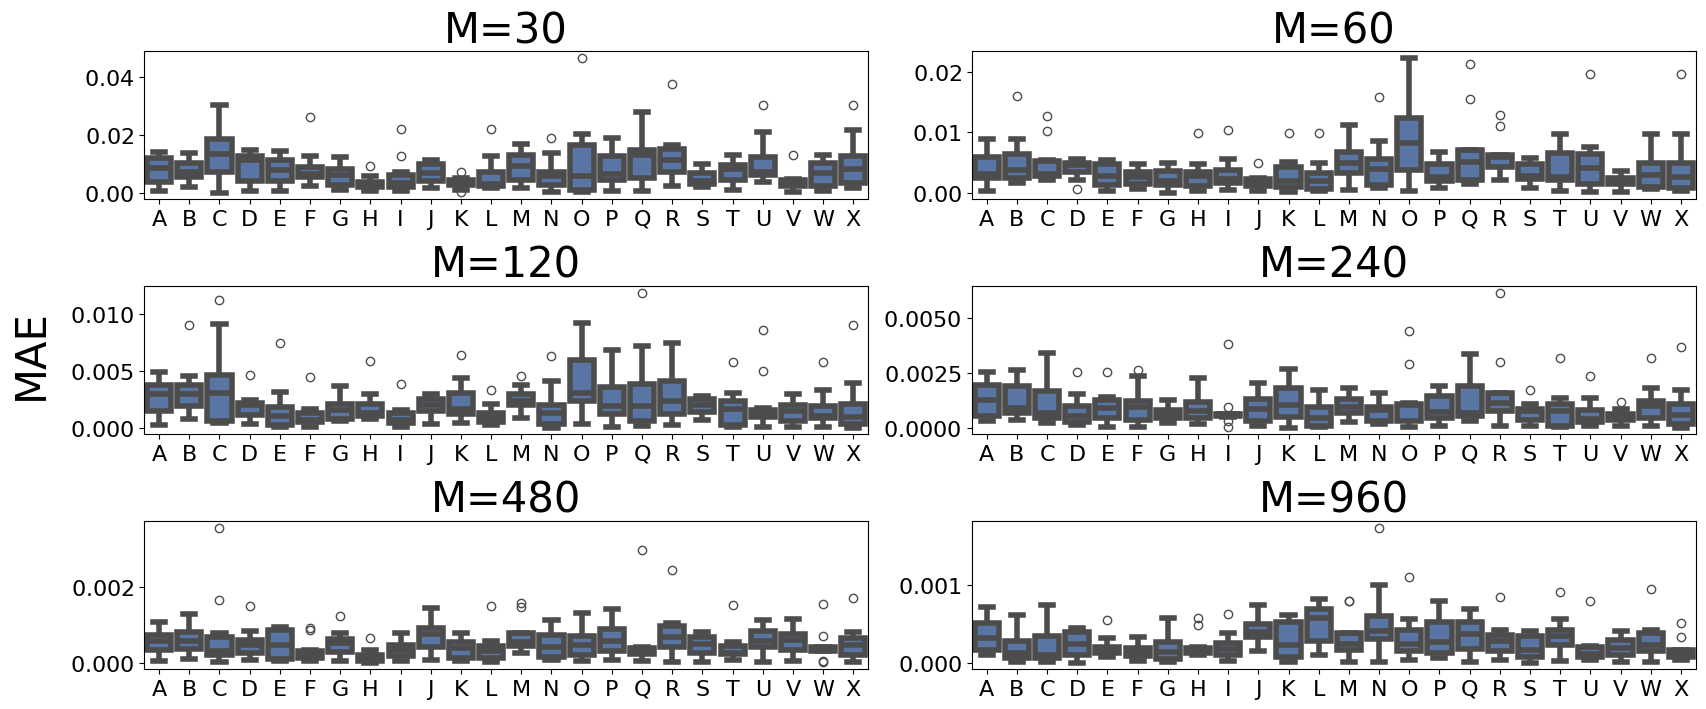

In [5]:
Ks = [0, 1, 7, 15]
wkls = ["IRM", "HE"]
alphas = [0.5, 0.8, 1.1]
pairs = list(itertools.product(wkls, Ks, alphas))
# labels = [f"{w}-K{k}-a{a:g}" for w, k, a in pairs]
labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:len(pairs)])

sns.set_palette("deep")
font_axes = 30
font_ticks = 16
line_width = 4
palette = sns.color_palette("deep", len(labels))
color_map = dict(zip(labels, palette))

mapping = {pk: lab for pk, lab in zip(pairs, labels)}
order = labels

df_plot = df_err.copy()
df_plot["method_param"] = list(zip(df_plot.workload, df_plot.K, df_plot.alpha))
df_plot["label"] = df_plot["method_param"].map(mapping)

M_list = [30, 60, 120, 240, 480, 960]
n_list = [10000000]

subplot_rows, subplot_cols = 3, 2
fig2, axes2 = plt.subplots(subplot_rows, subplot_cols, figsize=(18, 8),
                           sharex=False, sharey=False)
axes_flat = axes2.flatten()

for ax2, (M, n_val) in zip(axes_flat, itertools.product(M_list, n_list)):
    cell = df_plot[(df_plot.m == M) & (df_plot.n == n_val)].copy()
    sns.boxplot(x='label', y='abs_error', data=cell, ax=ax2,
                linewidth=line_width, order=order)
    ax2.set_title(f"M={M}", fontsize=font_axes)
    ax2.tick_params(labelsize=font_ticks)
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    # ax2.set_xticklabels(order, fontsize=font_ticks, rotation=0, ha='right')

fig2.text(0.025, 0.5, 'MAE', va='center', rotation='vertical',
          fontsize=font_axes)
plt.tight_layout(rect=[0.05, 0.05, 0.97, 0.95])
plt.savefig("figures/clock_k_mae.pdf", format='pdf')
plt.show()


In [ ]:
ms = [960]
Ks = [15]
for m in ms:
    for K in Ks:
        for tc in taus:
            C, hr = clock_k_he_torch(lmb, int(tc), K)
            print(f"C={C}, hr={hr}")

C=161, hr=0.4720028042793274
C=312, hr=0.6298704147338867
C=458, hr=0.7391267418861389


KeyboardInterrupt: 

In [ ]:
def _p_tauc(x, tail=1e-14, ncap=200000):
    p0 = np.exp(-x)
    if p0 == 0.0:
        p0 = np.finfo(np.float64).tiny
    pmf = [p0]
    s = p0
    n = 0
    while 1.0 - s > tail and n < ncap:
        n += 1
        pmf.append(pmf[-1] * x / n)
        s += pmf[-1]
    return np.asarray(pmf, np.float64), max(0.0, 1.0 - s)

def _g_tauc(P, x, tail=1e-14, ncap=200000):
    pmf, tail_mass = _p_tauc(x, tail=tail, ncap=ncap)
    d = P.shape[0]
    I = np.eye(d, dtype=np.float64)

    Pn = I.copy()
    Sn = np.zeros((d, d), np.float64)

    Pmix = np.zeros((d, d), np.float64)
    Smix = np.zeros((d, d), np.float64)

    for n, w in enumerate(pmf):
        if w:
            Pmix += w * Pn
            Smix += w * Sn
        Sn = Sn + Pn
        Pn = Pn @ P

    if tail_mass:
        Pmix += tail_mass * Pn
        Smix += tail_mass * Sn

    return Pmix, Smix

def clock_k_ph_linear(alphas, Ts, tc, K, tail=1e-14, ncap=200000):
    A = np.asarray(alphas, np.float64)
    T = np.asarray(Ts, np.float64)
    n, m = A.shape
    A = A / A.sum(axis=1, keepdims=True)
    tc = float(tc)
    K = int(K)

    one = np.ones(m, np.float64)

    mean_iat = np.empty(n, np.float64)
    for i in range(n):
        mean_iat[i] = float(A[i] @ np.linalg.solve(-T[i], one))
    lam = 1.0 / mean_iat
    w = lam / lam.sum()

    pm = 0.0
    occ = 0.0

    for i in range(n):
        a = A[i]
        Ti = T[i]
        qi = float(np.max(-np.diag(Ti)))
        B = np.eye(m, dtype=np.float64) + Ti / qi
        eta = (-(Ti @ one)) / qi
        U = (eta[:, None] * a[None, :])

        if K == 0:
            Pph = B + U
            Ptc, Ssum = _g_tauc(Pph, qi * tc, tail=tail, ncap=ncap)
            rho0 = a
            m_tc = float(rho0 @ (Ssum @ eta))
            pm_i = 1.0 / (1.0 + m_tc)
            pm += w[i] * pm_i
            occ += w[i] * pm_i
            continue

        N = (K + 1) * m
        blocks = [[np.zeros((m, m), np.float64) for _ in range(K + 1)] for _ in range(K + 1)]
        for k in range(K):
            blocks[k][k] = B
            blocks[k][k + 1] = U
        blocks[K][K] = B + U
        P = np.block(blocks)

        Ptc, Ssum = _g_tauc(P, qi * tc, tail=tail, ncap=ncap)

        g = np.tile(eta, K + 1)
        Nh = K * m
        Q = Ptc[:Nh, m:(K + 1) * m]
        h = (Ssum @ g)[:Nh]

        nu = np.zeros(Nh, np.float64)
        nu[:m] = a

        x = np.linalg.solve((np.eye(Nh, dtype=np.float64) - Q).T, nu)
        Oi = float(x.sum())
        Hi = float(x @ h)
        pm_i = 1.0 / (1.0 + Hi)

        pm += w[i] * pm_i
        occ += w[i] * pm_i * Oi

    C = int(round(tc * occ))
    return C, 1.0 - float(pm)

import torch

@torch.no_grad()
def clock_k_ph_torch(alphas, Ts, tc, K, tail=1e-14, ncap=200000, dtype=torch.float32, device=None):
    if device is None: device = torch.device("cpu")
    A = torch.as_tensor(alphas, dtype=dtype, device=device)
    T = torch.as_tensor(Ts, dtype=dtype, device=device)
    n, m = A.shape
    A = A / A.sum(dim=1, keepdim=True)
    tc = float(tc)
    K = int(K)

    one = torch.ones(m, dtype=dtype, device=device)

    mean_iat = torch.empty(n, dtype=dtype, device=device)
    for i in range(n):
        mean_iat[i] = A[i] @ torch.linalg.solve(-T[i], one)
    lam = 1.0 / mean_iat
    w = lam / lam.sum()

    def pois_pmf_trunc(x):
        x = float(x)
        p0 = np.exp(-x)
        if p0 == 0.0: p0 = np.finfo(np.float64).tiny
        pmf = [p0]
        s = p0
        k = 0
        while 1.0 - s > tail and k < ncap:
            k += 1
            pmf.append(pmf[-1] * x / k)
            s += pmf[-1]
        return pmf, max(0.0, 1.0 - s)

    def pois_mix_pow_sum(P, x):
        pmf, tail_mass = pois_pmf_trunc(x)
        d = P.shape[0]
        I = torch.eye(d, dtype=dtype, device=device)
        Pn = I.clone()
        Sn = torch.zeros_like(P)
        Pmix = torch.zeros_like(P)
        Smix = torch.zeros_like(P)
        for wgt in pmf:
            if wgt:
                Pmix = Pmix + (dtype.type(wgt) if hasattr(dtype, "type") else wgt) * Pn
                Smix = Smix + (dtype.type(wgt) if hasattr(dtype, "type") else wgt) * Sn
            Sn = Sn + Pn
            Pn = Pn @ P
        if tail_mass:
            tm = (dtype.type(tail_mass) if hasattr(dtype, "type") else tail_mass)
            Pmix = Pmix + tm * Pn
            Smix = Smix + tm * Sn
        return Pmix, Smix

    pm = torch.zeros((), dtype=dtype, device=device)
    occ = torch.zeros((), dtype=dtype, device=device)

    for i in range(n):
        a = A[i]
        Ti = T[i]
        qi = torch.max(-torch.diag(Ti)).item()
        B = torch.eye(m, dtype=dtype, device=device) + Ti / qi
        eta = (-(Ti @ one)) / qi
        U = eta[:, None] * a[None, :]

        if K == 0:
            Pph = B + U
            Ptc, Ssum = pois_mix_pow_sum(Pph, qi * tc)
            m_tc = (a @ (Ssum @ eta))
            pm_i = 1.0 / (1.0 + m_tc)
            pm = pm + w[i] * pm_i
            occ = occ + w[i] * pm_i
            continue

        N = (K + 1) * m
        P = torch.zeros((N, N), dtype=dtype, device=device)
        for k in range(K):
            r0 = k * m
            P[r0:r0+m, r0:r0+m] = B
            P[r0:r0+m, r0+m:r0+2*m] = U
        rK = K * m
        P[rK:rK+m, rK:rK+m] = B + U

        Ptc, Ssum = pois_mix_pow_sum(P, qi * tc)

        g = eta.expand(K + 1, m).reshape(-1)
        Nh = K * m
        Q = Ptc[:Nh, m:(K + 1) * m]
        h = (Ssum @ g)[:Nh]

        nu = torch.zeros(Nh, dtype=dtype, device=device)
        nu[:m] = a

        x = torch.linalg.solve((torch.eye(Nh, dtype=dtype, device=device) - Q).T, nu)
        Oi = x.sum()
        Hi = x @ h
        pm_i = 1.0 / (1.0 + Hi)

        pm = pm + w[i] * pm_i
        occ = occ + w[i] * pm_i * Oi

    C = int(torch.round(torch.tensor(tc, dtype=dtype, device=device) * occ).item())
    return C, float((1.0 - pm).item())

In [61]:
# m = 120
# n = 10000000
# a = 0.8
# mu_ratio = 10.0
# mu2 = (1.0 / mu_ratio + 1.0) / 2.0
# mu1 = mu_ratio * mu2
# T_base = np.array([[-mu1, 0.0], [0.0, -mu2]], dtype=np.float64)
# alphas = np.array([np.array([1/2, 1/2]) for _ in range(m)])
# p, _ = gen_from_zipf(m, n, a)
# Ts = np.array([p[i]*T_base for i in range(m)], dtype=np.float64)

trc_ph = gen_from_ph(alphas, Ts, n)
taus = gen_taus(m * 1.5, 10, power=0.95)
for tc in taus:
    cc_c_ph_pred, cc_hr_ph_pred = clock_k_ph_linear(alphas, Ts, tc, K=15)
    cc_c_ph_pred_torch, cc_hr_ph_pred_torch = clock_k_ph_torch(alphas, Ts, tc, K=15)
    cc_hr_ph_sim = tg.sim_clock(int(cc_c_ph_pred), trc_ph, raw=False, K=15)
    print(f"C_pred={cc_c_ph_pred}, hr_pred={cc_hr_ph_pred}, hr_sim={cc_hr_ph_sim}")
    print(f"C_pred_torch={cc_c_ph_pred_torch}, hr_pred_torch={cc_hr_ph_pred_torch}")
    print("----")

C_pred=18, hr_pred=0.5618126112332511, hr_sim=0.5528589057178115
C_pred_torch=18, hr_pred_torch=0.5618126392364502
----
C_pred=32, hr_pred=0.7012241146936421, hr_sim=0.6985594736616841
C_pred_torch=32, hr_pred_torch=0.7012240290641785
----
C_pred=43, hr_pred=0.7771689351162868, hr_sim=0.7730613475926246
C_pred_torch=43, hr_pred_torch=0.7771688103675842
----
C_pred=53, hr_pred=0.8263169922867807, hr_sim=0.8239902511142099
C_pred_torch=53, hr_pred_torch=0.8263168931007385
----
C_pred=62, hr_pred=0.8611104935883575, hr_sim=0.8606851650572
C_pred_torch=62, hr_pred_torch=0.8611103892326355
----
C_pred=69, hr_pred=0.8872104951112172, hr_sim=0.8849525928789668
C_pred_torch=69, hr_pred_torch=0.8872103691101074
----
C_pred=76, hr_pred=0.9075867822901199, hr_sim=0.9062118493285481
C_pred_torch=76, hr_pred_torch=0.9075866341590881
----
C_pred=82, hr_pred=0.9239454245864761, hr_sim=0.9226651533030661
C_pred_torch=82, hr_pred_torch=0.9239453077316284
----
C_pred=88, hr_pred=0.9373364819732642, hr_s